In [1]:
!pip install torch torchvision torchaudio
!pip install scikit-learn matplotlib seaborn pandas numpy scipy
!pip install torch-geometric
!pip install plotly

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import scipy.sparse as sp
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
import random
from collections import defaultdict
import pickle
import warnings
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import urllib.request
import zipfile
import os
# Import necessary modules if they are not already imported in the first cell
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import pandas as pd
import scipy.sparse as sp
import os
import time
import random
from collections import defaultdict
from torch.cuda.amp import autocast, GradScaler
from plotly.subplots import make_subplots # Explicitly import make_subplots
import plotly.graph_objects as go # Explicitly import go
import plotly.express as px # Explicitly import px
import urllib.request # Explicitly import urllib.request
import zipfile # Explicitly import zipfile

warnings.filterwarnings('ignore')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set random seeds for reproducibility
def set_seed(seed=2019):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

set_seed(2019)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 105.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [2]:
import pandas as pd
import os
import requests
import zipfile
from collections import defaultdict

def create_kg_for_ml1m():
    """
    Downloads the original MovieLens 1M dataset and creates the necessary
    knowledge graph files (kg_final.txt, entity_list.txt, relation_list.txt)
    for use with the KGAT model.
    """
    data_dir = "data/ml-1m-original"
    output_dir = "data/ml-1m" # This is where your KGAT script expects the data

    os.makedirs(data_dir, exist_ok=True)
    os.makedirs(output_dir, exist_ok=True)

    # --- 1. Download and Extract the Original ML-1M Dataset ---
    zip_url = "https://files.grouplens.org/datasets/movielens/ml-1m.zip"
    zip_path = os.path.join(data_dir, "ml-1m.zip")
    movies_dat_path = os.path.join(data_dir, "ml-1m/movies.dat")

    if not os.path.exists(movies_dat_path):
        print("Downloading original MovieLens 1M dataset...")
        try:
            r = requests.get(zip_url, stream=True)
            r.raise_for_status()
            with open(zip_path, 'wb') as f:
                for chunk in r.iter_content(chunk_size=8192):
                    f.write(chunk)

            with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                zip_ref.extractall(data_dir)
            print("Dataset downloaded and extracted successfully.")
        except Exception as e:
            print(f"Error during download/extraction: {e}")
            return
    else:
        print("Original MovieLens 1M dataset already exists.")

    # --- 2. Read movies.dat and build the KG ---
    print("Building knowledge graph from movies.dat...")
    movies_df = pd.read_csv(
        movies_dat_path,
        sep='::',
        header=None,
        names=['movieId', 'title', 'genres'],
        engine='python',
        encoding='latin-1'
    )

    # The KGAT script expects item IDs to start from 0
    # We need a mapping from original movieId to new, continuous item IDs
    original_movie_ids = movies_df['movieId'].unique()
    movie_id_map = {original_id: new_id for new_id, original_id in enumerate(original_movie_ids)}

    n_items = len(movie_id_map)
    print(f"Found {n_items} unique items (movies).")

    # Create entities for genres
    all_genres = set()
    for genres in movies_df['genres']:
        all_genres.update(genres.split('|'))

    genre_list = sorted(list(all_genres))
    # Genre IDs will start after the last item ID
    genre_id_map = {genre: i + n_items for i, genre in enumerate(genre_list)}

    # --- 3. Generate the KG triples (head, relation, tail) ---
    kg_triples = []
    has_genre_relation_id = 0 # We only have one relation type

    for _, row in movies_df.iterrows():
        original_movie_id = row['movieId']
        if original_movie_id in movie_id_map:
            head_id = movie_id_map[original_movie_id]
            genres = row['genres'].split('|')
            for genre in genres:
                tail_id = genre_id_map[genre]
                kg_triples.append((head_id, has_genre_relation_id, tail_id))

    # --- 4. Write the required files ---

    # Write kg_final.txt
    kg_final_path = os.path.join(output_dir, 'kg_final.txt')
    with open(kg_final_path, 'w') as f:
        for h, r, t in kg_triples:
            f.write(f"{h}\t{r}\t{t}\n")
    print(f"Successfully created kg_final.txt with {len(kg_triples)} triples.")

    # Write entity_list.txt
    entity_list_path = os.path.join(output_dir, 'entity_list.txt')
    with open(entity_list_path, 'w') as f:
        f.write("org_id\tremap_id\n")
        for org_id, remap_id in movie_id_map.items():
            f.write(f"{org_id}\t{remap_id}\n")
        for genre, remap_id in genre_id_map.items():
            f.write(f"{genre}\t{remap_id}\n")
    print("Successfully created entity_list.txt.")

    # Write relation_list.txt
    relation_list_path = os.path.join(output_dir, 'relation_list.txt')
    with open(relation_list_path, 'w') as f:
        f.write("org_id\tremap_id\n")
        f.write(f"has_genre\t{has_genre_relation_id}\n")
    print("Successfully created relation_list.txt.")

    # Important: The KGAT script also needs train.txt and test.txt
    # We will just copy the SASRec ml-1m.txt to train.txt and create an empty test.txt
    import shutil
    sasrec_data_path = "data/ml-1m.txt"
    if os.path.exists(sasrec_data_path):
        shutil.copy(sasrec_data_path, os.path.join(output_dir, 'train.txt'))
        # Create an empty test file as KGAT's loader expects it
        open(os.path.join(output_dir, 'test.txt'), 'w').close()
        print("Copied interaction data to train.txt and created empty test.txt.")


# Run the function to create the files
create_kg_for_ml1m()

Dataset downloaded and extracted successfully.
Building knowledge graph from movies.dat...
Found 3883 unique items (movies).
Successfully created kg_final.txt with 6408 triples.
Successfully created entity_list.txt.
Successfully created relation_list.txt.


In [4]:
# Data Loader Implementation
class KGATDataLoader:
    def __init__(self, data_dir, batch_size=8192, batch_size_kg=16384):
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.batch_size_kg = batch_size_kg

        # Load data
        self._load_ratings()
        self._load_kg()
        self._load_relation_map() # <-- ADD THIS CALL

        # Create mappings and process data
        self._process_data()

    def _load_ratings(self):
        """Load user-item interactions"""
        train_file = os.path.join(self.data_dir, 'train.txt')
        test_file = os.path.join(self.data_dir, 'test.txt')

        self.train_user_dict = {}
        self.test_user_dict = {}

        # Load training data
        with open(train_file, 'r') as f:
            for line in f:
                if len(line.strip()) == 0:
                    continue
                items = line.strip().split()
                uid = int(items[0])
                self.train_user_dict[uid] = [int(i) for i in items[1:]]

        # Load test data
        with open(test_file, 'r') as f:
            for line in f:
                if len(line.strip()) == 0:
                    continue
                items = line.strip().split()
                uid = int(items[0])
                self.test_user_dict[uid] = [int(i) for i in items[1:]]

        self.n_users = max(max(self.train_user_dict.keys()), max(self.test_user_dict.keys())) + 1
        self.n_items = max([max(items) for items in self.train_user_dict.values()]) + 1

        print(f"Loaded {self.n_users} users and {self.n_items} items")

    def _load_kg(self):
        """Load knowledge graph"""
        kg_file = os.path.join(self.data_dir, 'kg_final.txt')

        self.kg_dict = defaultdict(list)
        self.all_h_list, self.all_r_list, self.all_t_list = [], [], []

        with open(kg_file, 'r') as f:
            for line in f:
                if len(line.strip()) == 0:
                    continue
                h, r, t = map(int, line.strip().split())
                self.kg_dict[h].append((r, t))
                self.all_h_list.append(h)
                self.all_r_list.append(r)
                self.all_t_list.append(t)

        # Convert to numpy for faster operations
        self.all_h_list = np.array(self.all_h_list)
        self.all_r_list = np.array(self.all_r_list)
        self.all_t_list = np.array(self.all_t_list)

        self.n_entities = max(max(self.all_h_list), max(self.all_t_list)) + 1
        self.n_relations = max(self.all_r_list) + 1

        print(f"Loaded knowledge graph with {self.n_entities} entities and {self.n_relations} relations")

    def _process_data(self):
        """Process data and create adjacency matrices"""
        # Create training interactions
        self.train_items = []
        for uid, items in self.train_user_dict.items():
            for iid in items:
                self.train_items.append([uid, iid])
        self.train_items = np.array(self.train_items)
        self.n_train = len(self.train_items)

        self.train_user_item_matrix = sp.csr_matrix((np.ones(self.n_train), (self.train_items[:, 0], self.train_items[:, 1])), shape=(self.n_users, self.n_items))

        # Create collaborative knowledge graph adjacency matrix
        self._create_adjacency_matrix()

        print(f"Processed {self.n_train} training interactions")

    def _create_adjacency_matrix(self):
        """Create adjacency matrix for collaborative knowledge graph"""
        n_nodes = self.n_users + self.n_entities

        # User-item interactions
        cf_rows, cf_cols, cf_data = [], [], []
        for uid, items in self.train_user_dict.items():
            for iid in items:
                cf_rows.extend([uid, self.n_users + iid])
                cf_cols.extend([self.n_users + iid, uid])
                cf_data.extend([1.0, 1.0])

        # Knowledge graph relations
        kg_rows = np.concatenate([self.n_users + self.all_h_list, self.n_users + self.all_t_list])
        kg_cols = np.concatenate([self.n_users + self.all_t_list, self.n_users + self.all_h_list])
        kg_data = np.ones(len(kg_rows))

        # Combine CF and KG
        rows = np.concatenate([cf_rows, kg_rows])
        cols = np.concatenate([cf_cols, kg_cols])
        data = np.concatenate([cf_data, kg_data])

        # Create sparse matrix
        self.adjacency_matrix = sp.coo_matrix((data, (rows, cols)), shape=(n_nodes, n_nodes))

        # Normalize adjacency matrix
        self.adjacency_matrix = self._normalize_adjacency_matrix(self.adjacency_matrix)

        # Convert to PyTorch sparse tensor and move to GPU immediately
        indices = torch.LongTensor([self.adjacency_matrix.row, self.adjacency_matrix.col]).to(device)
        values = torch.FloatTensor(self.adjacency_matrix.data).to(device)
        self.adjacency_tensor = torch.sparse.FloatTensor(indices, values,
                                                        torch.Size(self.adjacency_matrix.shape)).to(device)

    def _normalize_adjacency_matrix(self, adj_matrix):
        """Normalize adjacency matrix"""
        adj_matrix = adj_matrix + sp.eye(adj_matrix.shape[0])
        degrees = np.array(adj_matrix.sum(axis=1)).flatten()
        d_inv_sqrt = np.power(degrees, -0.5)
        d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
        d_mat_inv_sqrt = sp.diags(d_inv_sqrt)
        return d_mat_inv_sqrt.dot(adj_matrix).dot(d_mat_inv_sqrt).tocoo()

    def generate_train_batch(self):
        """Generate training batch for CF - FULLY VECTORIZED"""
        # 1. Sample positive interactions directly from the training data
        indices = np.random.choice(self.n_train, self.batch_size)
        users = self.train_items[indices][:, 0]
        pos_items = self.train_items[indices][:, 1]

        # 2. Generate random negative items for all samples at once
        neg_items = np.random.randint(0, self.n_items, size=self.batch_size)

        # 3. Efficiently find and replace collisions (where neg_item is a true pos_item)
        # This loop is very fast as it only runs a few times for the rare collisions
        collisions = (self.train_user_item_matrix[users, neg_items].A.flatten() == 1)
        while np.any(collisions):
            num_collisions = np.sum(collisions)
            # Generate new random negative items ONLY for the collided samples
            new_neg_items = np.random.randint(0, self.n_items, size=num_collisions)
            # Replace the collided items
            neg_items[collisions] = new_neg_items
            # Check for new collisions on the updated items
            collisions = (self.train_user_item_matrix[users, neg_items].A.flatten() == 1)

        return torch.LongTensor(users).to(device), torch.LongTensor(pos_items).to(device), torch.LongTensor(neg_items).to(device)

    def generate_kg_batch(self):
        """Generate training batch for KG - vectorized"""
        # Sample random indices
        indices = np.random.choice(len(self.all_h_list), self.batch_size_kg)

        heads = self.all_h_list[indices]
        relations = self.all_r_list[indices]
        pos_tails = self.all_t_list[indices]

        # Sample negative tails
        neg_tails = np.random.randint(0, self.n_entities, self.batch_size_kg)

        return (torch.LongTensor(heads).to(device), torch.LongTensor(relations).to(device),
                torch.LongTensor(pos_tails).to(device), torch.LongTensor(neg_tails).to(device))
    def _load_relation_map(self):
        """
        Load the mapping from relation ID to a clean, human-readable relation name.
        This function parses long URLs to extract meaningful keywords.
        """
        self.relation_map = {}
        relation_file = os.path.join(self.data_dir, 'relation.txt')

        if os.path.exists(relation_file):
            with open(relation_file, 'r') as f:
                for line in f:
                    try:
                        parts = line.strip().split()
                        if len(parts) == 2:
                            relation_id = int(parts[1])
                            full_name = parts[0]

                            # --- NEW: Parse the long name to get a clean version ---
                            if '#' in full_name:
                                clean_name = full_name.split('#')[-1]
                            else:
                                clean_name = full_name.split('/')[-1].split('.')[-1]

                            self.relation_map[relation_id] = clean_name

                    except ValueError:
                        # This will catch errors from header lines
                        print(f"Skipping header or malformed line in relation.txt: {line.strip()}")
                        continue
        else:
            print("Warning: relation.txt not found. Cluster interpretation will use IDs instead of names.")

In [5]:
# KGAT Model Implementation
class KGAT(nn.Module):
    def __init__(self, data_loader, embed_size=64, layer_sizes=[64, 32, 16],
                 kge_size=64, regs=[1e-5, 1e-5], alg_type='bi',
                 node_dropout=0.1, mess_dropout=0.1):
        super(KGAT, self).__init__()

        self.data_loader = data_loader
        self.n_users = data_loader.n_users
        self.n_items = data_loader.n_items
        self.n_entities = data_loader.n_entities
        self.n_relations = data_loader.n_relations

        self.embed_size = embed_size
        self.layer_sizes = layer_sizes
        self.kge_size = kge_size
        self.n_layers = len(layer_sizes)
        self.regs = regs
        self.alg_type = alg_type
        self.node_dropout = node_dropout
        self.mess_dropout = mess_dropout

        # Initialize embeddings
        self.user_embed = nn.Embedding(self.n_users, embed_size)
        self.entity_embed = nn.Embedding(self.n_entities, embed_size)
        self.relation_embed = nn.Embedding(self.n_relations, kge_size)

        # TransR transformation matrices
        self.trans_W = nn.Parameter(torch.Tensor(self.n_relations, embed_size, kge_size))

        # GNN layers
        self.gnn_layers = nn.ModuleList()
        input_size = embed_size
        for i, output_size in enumerate(layer_sizes):
            self.gnn_layers.append(GNNLayer(input_size, output_size, alg_type, mess_dropout))
            input_size = output_size

        self._init_weights()

    def _init_weights(self):
        """Initialize model weights"""
        nn.init.xavier_uniform_(self.user_embed.weight)
        nn.init.xavier_uniform_(self.entity_embed.weight)
        nn.init.xavier_uniform_(self.relation_embed.weight)
        nn.init.xavier_uniform_(self.trans_W)

    def forward(self, users, pos_items, neg_items):
        """Forward pass for recommendation"""
        # Get embeddings after message passing
        user_embeddings, entity_embeddings = self._get_ego_embeddings()

        # Look up user and item embeddings
        user_emb = user_embeddings[users]
        pos_item_emb = entity_embeddings[pos_items]
        neg_item_emb = entity_embeddings[neg_items]

        return user_emb, pos_item_emb, neg_item_emb

    def _get_ego_embeddings(self):
        """Get embeddings through message passing"""
        # Concatenate user and entity embeddings
        ego_embeddings = torch.cat([self.user_embed.weight, self.entity_embed.weight], dim=0)
        all_embeddings = [ego_embeddings]

        # Message passing through layers
        for i, gnn_layer in enumerate(self.gnn_layers):
            ego_embeddings = gnn_layer(ego_embeddings, self.data_loader.adjacency_tensor)
            all_embeddings.append(ego_embeddings)

        # Concatenate embeddings from all layers
        final_embeddings = torch.cat(all_embeddings, dim=1)

        # Split user and entity embeddings
        user_embeddings = final_embeddings[:self.n_users]
        entity_embeddings = final_embeddings[self.n_users:]

        return user_embeddings, entity_embeddings

    def calc_kg_loss(self, heads, relations, pos_tails, neg_tails):
        """Calculate knowledge graph embedding loss"""
        # Get entity embeddings
        h_emb = self.entity_embed(heads)
        pos_t_emb = self.entity_embed(pos_tails)
        neg_t_emb = self.entity_embed(neg_tails)

        # Get relation embeddings and transformation matrices
        r_emb = self.relation_embed(relations)
        trans_M = self.trans_W[relations]

        # Apply TransR transformation - vectorized
        h_emb = torch.bmm(h_emb.unsqueeze(1), trans_M).squeeze(1)
        pos_t_emb = torch.bmm(pos_t_emb.unsqueeze(1), trans_M).squeeze(1)
        neg_t_emb = torch.bmm(neg_t_emb.unsqueeze(1), trans_M).squeeze(1)

        # Calculate scores - vectorized
        pos_score = torch.sum((h_emb + r_emb - pos_t_emb) ** 2, dim=1)
        neg_score = torch.sum((h_emb + r_emb - neg_t_emb) ** 2, dim=1)

        # BPR loss
        kg_loss = torch.mean(F.softplus(pos_score - neg_score))

        # L2 regularization
        l2_loss = torch.mean(h_emb ** 2) + torch.mean(r_emb ** 2) + torch.mean(pos_t_emb ** 2) + torch.mean(neg_t_emb ** 2)

        return kg_loss, l2_loss

    def calc_cf_loss(self, user_emb, pos_item_emb, neg_item_emb):
        """Calculate collaborative filtering loss"""
        pos_scores = torch.sum(user_emb * pos_item_emb, dim=1)
        neg_scores = torch.sum(user_emb * neg_item_emb, dim=1)

        # BPR loss
        cf_loss = torch.mean(F.softplus(neg_scores - pos_scores))

        # L2 regularization
        l2_loss = torch.mean(user_emb ** 2) + torch.mean(pos_item_emb ** 2) + torch.mean(neg_item_emb ** 2)

        return cf_loss, l2_loss

class GNNLayer(nn.Module):
    def __init__(self, input_size, output_size, alg_type='bi', dropout=0.1):
        super(GNNLayer, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.alg_type = alg_type
        self.dropout = dropout

        if alg_type == 'gcn':
            self.linear = nn.Linear(input_size, output_size)
        elif alg_type == 'bi':
            self.W_gc = nn.Linear(input_size, output_size)
            self.W_bi = nn.Linear(input_size, output_size)
        elif alg_type == 'graphsage':
            self.W_mlp = nn.Linear(2 * input_size, output_size)

        self.dropout_layer = nn.Dropout(dropout)

    def forward(self, embeddings, adjacency_matrix):
        if self.alg_type == 'gcn':
            # GCN aggregation
            neighbor_embeddings = torch.sparse.mm(adjacency_matrix, embeddings)
            output = F.leaky_relu(self.linear(neighbor_embeddings))

        elif self.alg_type == 'bi':
            # Bi-interaction aggregation
            neighbor_embeddings = torch.sparse.mm(adjacency_matrix, embeddings)

            # Sum aggregation
            sum_embeddings = F.leaky_relu(self.W_gc(embeddings + neighbor_embeddings))

            # Bi-interaction
            bi_embeddings = F.leaky_relu(self.W_bi(embeddings * neighbor_embeddings))

            output = sum_embeddings + bi_embeddings

        elif self.alg_type == 'graphsage':
            # GraphSAGE aggregation
            neighbor_embeddings = torch.sparse.mm(adjacency_matrix, embeddings)
            concat_embeddings = torch.cat([embeddings, neighbor_embeddings], dim=1)
            output = F.relu(self.W_mlp(concat_embeddings))

        # Apply dropout and normalization
        output = self.dropout_layer(output)
        output = F.normalize(output, p=2, dim=1)

        return output

In [6]:
# Optimize the existing KGATTrainer class
from torch.cuda.amp import autocast, GradScaler

class KGATTrainer:
    def __init__(self, model, data_loader, lr=0.001, reg_weight=1e-5):
        self.model = model.to(device)
        self.data_loader = data_loader
        self.optimizer = optim.AdamW(self.model.parameters(), lr=lr, weight_decay=reg_weight)
        self.reg_weight = reg_weight
        # Remove mixed precision scaler since sparse ops don't support it

    def train_epoch(self):
        self.model.train()
        total_cf_loss = 0
        total_kg_loss = 0
        n_cf_batch = self.data_loader.n_train // self.data_loader.batch_size + 1
        n_kg_batch = len(self.data_loader.all_h_list) // self.data_loader.batch_size_kg + 1

        # Phase 1: Train CF part - no mixed precision due to sparse operations
        for _ in range(n_cf_batch):
            users, pos_items, neg_items = self.data_loader.generate_train_batch()

            self.optimizer.zero_grad()

            # No autocast here due to sparse matrix operations
            user_emb, pos_item_emb, neg_item_emb = self.model(users, pos_items, neg_items)
            cf_loss, cf_l2_loss = self.model.calc_cf_loss(user_emb, pos_item_emb, neg_item_emb)
            loss = cf_loss + self.reg_weight * cf_l2_loss

            loss.backward()
            self.optimizer.step()

            total_cf_loss += loss.item()

        # Phase 2: Train KG part - can use mixed precision here
        for _ in range(n_kg_batch):
            heads, relations, pos_tails, neg_tails = self.data_loader.generate_kg_batch()

            self.optimizer.zero_grad()

            # KG operations don't use sparse matrices, so mixed precision is OK
            with autocast():
                kg_loss, kg_l2_loss = self.model.calc_kg_loss(heads, relations, pos_tails, neg_tails)
                loss = kg_loss + self.reg_weight * kg_l2_loss

            loss.backward()
            self.optimizer.step()

            total_kg_loss += loss.item()

        return total_cf_loss / n_cf_batch, total_kg_loss / n_kg_batch

    def evaluate(self, k_values=[20]):
        self.model.eval()

        with torch.no_grad():
            # Get the final embeddings after all GNN layers
            user_embeddings, entity_embeddings = self.model._get_ego_embeddings()

            results = {f'recall@{k}': [] for k in k_values}
            results.update({f'ndcg@{k}': [] for k in k_values})

            # Determine which users to test on
            test_users = list(self.data_loader.test_user_dict.keys())
            if len(test_users) > 1000:  # Sample for speed if the test set is large
                test_users = np.random.choice(test_users, 1000, replace=False).tolist()

            eval_batch_size = 16384

            # Process users in batches for efficiency
            for i in range(0, len(test_users), eval_batch_size):
                batch_users = test_users[i:i + eval_batch_size]
                batch_user_indices = torch.LongTensor(batch_users).to(device)

                # Get embeddings for the current batch of users
                user_embs_batch = user_embeddings[batch_user_indices]

                # Calculate scores against ALL items for the entire batch in one go
                # This is the most significant optimization
                scores_batch = torch.mm(user_embs_batch, entity_embeddings.t())

                # Exclude items that users have already seen in the training set
                for j, uid in enumerate(batch_users):
                    if uid in self.data_loader.train_user_dict:
                        train_items_to_exclude = self.data_loader.train_user_dict[uid]
                        scores_batch[j, train_items_to_exclude] = -float('inf')

                # Get top-k recommendations for the entire batch at once
                # We get the largest K value needed, then slice it for smaller Ks
                max_k = max(k_values)
                _, top_k_items_batch = torch.topk(scores_batch, k=max_k)
                top_k_items_batch = top_k_items_batch.cpu().numpy()

                # Now, calculate metrics for each user in the batch
                for j, uid in enumerate(batch_users):
                    test_items = self.data_loader.test_user_dict[uid]
                    if not test_items:
                        continue

                    for k in k_values:
                        # Get the top-k items for the current user from the batch results
                        top_k_for_user = top_k_items_batch[j, :k]
                        hit_items = set(top_k_for_user) & set(test_items)

                        # Calculate Recall
                        recall = len(hit_items) / len(test_items)
                        results[f'recall@{k}'].append(recall)

                        # Calculate NDCG
                        # Create a binary relevance mask for the top-k items
                        relevance_mask = np.isin(top_k_for_user, test_items).astype(float)
                        # Calculate DCG
                        dcg = np.sum(relevance_mask / np.log2(np.arange(2, k + 2)))
                        # Calculate IDCG
                        idcg = np.sum(1.0 / np.log2(np.arange(2, min(len(test_items), k) + 2)))
                        ndcg = dcg / idcg if idcg > 0 else 0
                        results[f'ndcg@{k}'].append(ndcg)

            # Average the results
            final_results = {}
            for metric, values in results.items():
                final_results[metric] = np.mean(values) if values else 0.0

        return final_results

In [7]:
import urllib.request
import zipfile
import os

def download_dataset(dataset_name):
    """
    Download dataset from GitHub, including relation lists and handling both
    .zip and direct .txt files for the knowledge graph.
    """
    base_url = "https://github.com/xiangwang1223/knowledge_graph_attention_network/raw/master/Data"
    data_dir = f"data/{dataset_name}"
    os.makedirs(data_dir, exist_ok=True)

    # --- MODIFIED: Download common files including relation_list.txt ---
    files_to_download = ['train.txt', 'test.txt', 'relation_list.txt']
    for file in files_to_download:
        url = f"{base_url}/{dataset_name}/{file}"
        file_path = os.path.join(data_dir, file.replace('_list', '')) # Saves as relation.txt
        if not os.path.exists(file_path):
            try:
                print(f"Downloading {file} for {dataset_name}...")
                urllib.request.urlretrieve(url, file_path)
                print(f"Downloaded {file}")
            except Exception as e:
                print(f"Could not download {file}: {e}")
        else:
            print(f"{file} for {dataset_name} already exists.")

    # Robust logic for knowledge graph file (remains the same)
    kg_txt_path = os.path.join(data_dir, "kg_final.txt")
    if os.path.exists(kg_txt_path):
        print(f"kg_final.txt for {dataset_name} already exists.")
    else:
        kg_zip_url = f"{base_url}/{dataset_name}/kg_final.txt.zip"
        kg_zip_path = os.path.join(data_dir, "kg_final.txt.zip")
        try:
            print(f"Attempting to download and extract kg_final.txt.zip for {dataset_name}...")
            urllib.request.urlretrieve(kg_zip_url, kg_zip_path)
            with zipfile.ZipFile(kg_zip_path, 'r') as zip_ref:
                zip_ref.extractall(data_dir)
            print(f"Downloaded and extracted kg_final.txt.zip")
            os.remove(kg_zip_path)
        except Exception:
            print(f"Could not find kg_final.txt.zip. Trying to download kg_final.txt directly...")
            kg_txt_url = f"{base_url}/{dataset_name}/kg_final.txt"
            try:
                urllib.request.urlretrieve(kg_txt_url, kg_txt_path)
                print(f"Successfully downloaded kg_final.txt")
            except Exception as e_txt:
                print(f"Critical Error: Failed to download the knowledge graph for {dataset_name} in any format: {e_txt}")


In [8]:
# Training Loop and Visualization
class ResultsVisualizer:
    def __init__(self):
        self.results = {}

    def add_result(self, dataset, epoch, metrics):
        if dataset not in self.results:
            self.results[dataset] = {'epochs': [], 'metrics': {}}

        self.results[dataset]['epochs'].append(epoch)
        for metric, value in metrics.items():
            if metric not in self.results[dataset]['metrics']:
                self.results[dataset]['metrics'][metric] = []
            self.results[dataset]['metrics'][metric].append(value)

    def plot_training_curves(self):
        """Plot training curves for all datasets"""
        datasets = list(self.results.keys())
        n_datasets = len(datasets)

        # Add a check to ensure there are datasets to plot
        if n_datasets == 0:
            print("No training results available to plot training curves.")
            return

        fig = make_subplots(
            rows=2, cols=n_datasets,
            subplot_titles=[f"{dataset} - Recall@20" for dataset in datasets] +
                          [f"{dataset} - NDCG@20" for dataset in datasets],
            vertical_spacing=0.1
        )

        colors = px.colors.qualitative.Set1

        for i, dataset in enumerate(datasets):
            if 'recall@20' in self.results[dataset]['metrics']:
                # Recall plot
                fig.add_trace(
                    go.Scatter(
                        x=self.results[dataset]['epochs'],
                        y=self.results[dataset]['metrics']['recall@20'],
                        mode='lines+markers',
                        name=f'{dataset} Recall@20',
                        line=dict(color=colors[i % len(colors)]),
                        showlegend=True
                    ),
                    row=1, col=i+1
                )

                # NDCG plot
                fig.add_trace(
                    go.Scatter(
                        x=self.results[dataset]['epochs'],
                        y=self.results[dataset]['metrics']['ndcg@20'],
                        mode='lines+markers',
                        name=f'{dataset} NDCG@20',
                        line=dict(color=colors[i % len(colors)], dash='dash'),
                        showlegend=True
                    ),
                    row=2, col=i+1
                )

        fig.update_layout(
            title_text="KGAT Training Progress Across Datasets",
            height=600,
            showlegend=True
        )

        fig.show()

    def plot_final_comparison(self):
        """Plot final performance comparison"""
        datasets = list(self.results.keys())

        # Add a check to ensure there are datasets to plot
        if len(datasets) == 0:
            print("No final results available to plot comparison.")
            return {}


        metrics = ['recall@20', 'ndcg@20']

        final_results = {}
        for dataset in datasets:
            final_results[dataset] = {}
            for metric in metrics:
                if metric in self.results[dataset]['metrics']:
                    final_results[dataset][metric] = self.results[dataset]['metrics'][metric][-1]

        # Create comparison bar plot
        fig = make_subplots(
            rows=1, cols=2,
            subplot_titles=['Recall@20', 'NDCG@20'],
            specs=[[{"secondary_y": False}, {"secondary_y": False}]]
        )

        for i, metric in enumerate(metrics):
            values = [final_results[dataset].get(metric, 0) for dataset in datasets]

            fig.add_trace(
                go.Bar(
                    x=datasets,
                    y=values,
                    name=metric,
                    text=[f'{v:.4f}' for v in values],
                    textposition='auto',
                ),
                row=1, col=i+1
            )

        fig.update_layout(
            title_text="Final Performance Comparison",
            height=400,
            showlegend=False
        )

        fig.show()

        return final_results

# Update the training function to use larger batches and better optimization
def train_kgat_on_datasets():
    """Train KGAT on all datasets with A100 optimizations"""
    visualizer = ResultsVisualizer()
    final_results = {}

    datasets = ['amazon-book', 'last-fm', 'yelp2018','ml-1m']

    for dataset in datasets:
        print(f"\n{'='*50}")
        print(f"Training on {dataset}")
        print(f"{'='*50}")

        # Check if data exists, if not download
        required_files = ['train.txt', 'test.txt', 'kg_final.txt']
        data_dir = f"data/{dataset}"

        if not os.path.exists(data_dir) or not all(os.path.exists(os.path.join(data_dir, f)) for f in required_files):
            print(f"Dataset {dataset} not found. Attempting to download...")
            download_dataset(dataset)

            # Check if download was successful
            if not all(os.path.exists(os.path.join(data_dir, f)) for f in required_files):
                print(f"Download failed or incomplete for {dataset}. Skipping...")
                continue

        try:
            # Load data with your batch sizes
            data_loader = KGATDataLoader(data_dir, batch_size=16384, batch_size_kg=32768)

            # Create model with larger dimensions for A100
            model = KGAT(
                data_loader=data_loader,
                embed_size=128,  # Increased for A100
                layer_sizes=[128, 64, 32],  # Larger layers
                alg_type='bi',
                node_dropout=0.1,
                mess_dropout=0.1
            )

            print(f"Model has {sum(p.numel() for p in model.parameters()):,} parameters")

            # Create trainer with higher learning rate
            trainer = KGATTrainer(model, data_loader, lr=0.002)

            # Training loop
            epochs = 50
            best_recall = 0
            patience = 10
            patience_counter = 0

            for epoch in range(epochs):
                start_time = time.time()

                # Train
                cf_loss, kg_loss = trainer.train_epoch()

                # Evaluate every 5 epochs
                if (epoch + 1) % 5 == 0:
                    metrics = trainer.evaluate(k_values=[20])
                    epoch_time = time.time() - start_time

                    print(f"Epoch {epoch+1:3d} | CF Loss: {cf_loss:.4f} | KG Loss: {kg_loss:.4f} | "
                          f"Recall@20: {metrics['recall@20']:.4f} | NDCG@20: {metrics['ndcg@20']:.4f} | "
                          f"Time: {epoch_time:.2f}s")

                    # Add to visualizer
                    visualizer.add_result(dataset, epoch+1, metrics)

                    # Early stopping
                    if metrics['recall@20'] > best_recall:
                        best_recall = metrics['recall@20']
                        patience_counter = 0
                        # Save best model
                        torch.save(model.state_dict(), f'best_model_{dataset}.pth')
                    else:
                        patience_counter += 1

                    if patience_counter >= patience:
                        print(f"Early stopping at epoch {epoch+1}")
                        break
                else:
                    epoch_time = time.time() - start_time
                    print(f"Epoch {epoch+1:3d} | CF Loss: {cf_loss:.4f} | KG Loss: {kg_loss:.4f} | Time: {epoch_time:.2f}s")

            # Final evaluation
            model.load_state_dict(torch.load(f'best_model_{dataset}.pth'))
            final_metrics = trainer.evaluate(k_values=[10, 20, 50])
            final_results[dataset] = final_metrics

            print(f"\nFinal results for {dataset}:")
            for metric, value in final_metrics.items():
                print(f"  {metric}: {value:.4f}")

            # Clean up GPU memory
            del model, trainer
            torch.cuda.empty_cache()

        except Exception as e:
            print(f"Error training on {dataset}: {e}")
            import traceback
            traceback.print_exc()
            continue

    # Visualize results
    if final_results:
        print(f"\n{'='*50}")
        print("Generating visualizations...")
        print(f"{'='*50}")

        visualizer.plot_training_curves()
        final_comparison = visualizer.plot_final_comparison()
    else:
        print("No results were collected from any dataset. Skipping visualizations.")

    return final_results, visualizer

# Run training
if __name__ == "__main__":
    # Set device
    results, viz = train_kgat_on_datasets()

    # Print summary
    print(f"\n{'='*50}")
    print("TRAINING SUMMARY")
    print(f"{'='*50}")

    if results:
        for dataset, metrics in results.items():
            print(f"\n{dataset}:")
            for metric, value in metrics.items():
                print(f"  {metric}: {value:.4f}")
    else:
        print("No training completed successfully for any dataset.")


Training on amazon-book
Dataset amazon-book not found. Attempting to download...
Downloaded train.txt
Downloaded test.txt
Downloaded relation_list.txt
Attempting to download and extract kg_final.txt.zip for amazon-book...
Downloaded and extracted kg_final.txt.zip
Loaded 70679 users and 24915 items
Loaded knowledge graph with 113487 entities and 39 relations
Skipping header or malformed line in relation.txt: org_id remap_id
Processed 652514 training interactions
Model has 23,948,928 parameters
Epoch   1 | CF Loss: 0.6476 | KG Loss: 0.3021 | Time: 25.69s
Epoch   2 | CF Loss: 0.4273 | KG Loss: 0.1985 | Time: 24.59s
Epoch   3 | CF Loss: 0.3233 | KG Loss: 0.1850 | Time: 24.81s
Epoch   4 | CF Loss: 0.2839 | KG Loss: 0.1798 | Time: 25.11s
Epoch   5 | CF Loss: 0.2613 | KG Loss: 0.1771 | Recall@20: 0.0317 | NDCG@20: 0.0155 | Time: 25.51s
Epoch   6 | CF Loss: 0.2444 | KG Loss: 0.1751 | Time: 25.00s
Epoch   7 | CF Loss: 0.2315 | KG Loss: 0.1738 | Time: 25.07s
Epoch   8 | CF Loss: 0.2191 | KG Los


TRAINING SUMMARY

amazon-book:
  recall@10: 0.0544
  recall@20: 0.0898
  recall@50: 0.1573
  ndcg@10: 0.0332
  ndcg@20: 0.0441
  ndcg@50: 0.0606

last-fm:
  recall@10: 0.0455
  recall@20: 0.0656
  recall@50: 0.0983
  ndcg@10: 0.0548
  ndcg@20: 0.0601
  ndcg@50: 0.0709

yelp2018:
  recall@10: 0.0298
  recall@20: 0.0472
  recall@50: 0.1014
  ndcg@10: 0.0247
  ndcg@20: 0.0312
  ndcg@50: 0.0480


In [38]:
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import KMeans
from collections import Counter

In [39]:
# Additional utilities for analysis and debugging
class KGATAnalyzer:
    def __init__(self, model, data_loader):
        self.model = model.to(device)
        self.data_loader = data_loader

    def _calculate_metrics(self, high_dim_embeds, low_dim_embeds, k=10):
        """Helper function to calculate Neighborhood Preservation and Local Distance Distortion."""
        # Find k-nearest neighbors in both high and low dimensional spaces
        nn_high = NearestNeighbors(n_neighbors=k+1).fit(high_dim_embeds)
        high_dim_neighbors = nn_high.kneighbors(high_dim_embeds, return_distance=False)[:, 1:]

        nn_low = NearestNeighbors(n_neighbors=k+1).fit(low_dim_embeds)
        low_dim_neighbors = nn_low.kneighbors(low_dim_embeds, return_distance=False)[:, 1:]

        # --- 1. Neighborhood Preservation (NP) ---
        # For each point, find the number of shared neighbors
        np_scores = [len(set(high_dim_neighbors[i]) & set(low_dim_neighbors[i])) / k for i in range(len(high_dim_embeds))]
        np_metric = np.mean(np_scores)

        # --- 2. Local Distance Distortion (LDD) ---
        high_dim_dists = squareform(pdist(high_dim_embeds, 'euclidean'))
        low_dim_dists = squareform(pdist(low_dim_embeds, 'euclidean'))

        ldd_scores = []
        for i in range(len(high_dim_embeds)):
            # Get distances to k-nearest neighbors in the high-dimensional space
            high_neighbors_idx = high_dim_neighbors[i]

            dist_diffs = np.abs(high_dim_dists[i, high_neighbors_idx] - low_dim_dists[i, high_neighbors_idx])
            sum_of_high_dists = np.sum(high_dim_dists[i, high_neighbors_idx])

            if sum_of_high_dists > 0:
                ldd_scores.append(np.sum(dist_diffs) / sum_of_high_dists)

        ldd_metric = np.mean(ldd_scores) if ldd_scores else 0

        return np_metric, ldd_metric

    def plot_tsne_and_metrics(self, n_samples=500, k=10, n_user_clusters=5, n_entity_clusters=8):
        """
        Generates t-SNE plots, calculates metrics, and interprets the entity clusters
        by filtering out common, uninformative relations.
        """
        # (The first part of the function for sampling, t-SNE, and plotting remains the same)
        self.model.eval()
        with torch.no_grad():
            print(f"Running t-SNE and calculating metrics on a sample of {n_samples} users/entities...")
            user_embeddings, entity_embeddings = self.model._get_ego_embeddings()

            user_indices = np.random.choice(user_embeddings.shape[0], min(n_samples, user_embeddings.shape[0]), replace=False)
            entity_indices = np.random.choice(entity_embeddings.shape[0], min(n_samples, entity_embeddings.shape[0]), replace=False)
            sampled_users = user_embeddings[user_indices].cpu().numpy()
            sampled_entities = entity_embeddings[entity_indices].cpu().numpy()

            all_embeds_high_dim = np.vstack([sampled_users, sampled_entities])
            tsne_combined = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
            all_embeds_low_dim = tsne_combined.fit_transform(all_embeds_high_dim)
            np_metric, ldd_metric = self._calculate_metrics(all_embeds_high_dim, all_embeds_low_dim, k=k)
            print("\n--- Embedding Quality Metrics ---")
            print(f"Neighborhood Preservation (NP@{k}): {np_metric:.4f}")
            print(f"Local Distance Distortion (LDD@{k}): {ldd_metric:.4f}")
            print("---------------------------------\n")

            kmeans_users = KMeans(n_clusters=n_user_clusters, random_state=42, n_init=10).fit(sampled_users)
            tsne_users = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
            user_embeds_low_dim = tsne_users.fit_transform(sampled_users)

            kmeans_entities = KMeans(n_clusters=n_entity_clusters, random_state=42, n_init=10).fit(sampled_entities)
            tsne_entities = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
            entity_embeds_low_dim = tsne_entities.fit_transform(sampled_entities)

            fig, axes = plt.subplots(1, 3, figsize=(30, 8))
            sns.scatterplot(x=all_embeds_low_dim[:, 0], y=all_embeds_low_dim[:, 1], hue=['User'] * len(sampled_users) + ['Entity'] * len(sampled_entities), palette=sns.color_palette("hls", 2), ax=axes[0], alpha=0.6)
            axes[0].set_title('Combined t-SNE of Users and Entities')
            sns.scatterplot(x=user_embeds_low_dim[:, 0], y=user_embeds_low_dim[:, 1], hue=kmeans_users.labels_, palette=sns.color_palette("viridis", n_user_clusters), ax=axes[1], alpha=0.7)
            axes[1].set_title(f'{n_user_clusters} User Clusters (t-SNE)')
            sns.scatterplot(x=entity_embeds_low_dim[:, 0], y=entity_embeds_low_dim[:, 1], hue=kmeans_entities.labels_, palette=sns.color_palette("plasma", n_entity_clusters), ax=axes[2], alpha=0.7)
            axes[2].set_title(f'{n_entity_clusters} Entity Clusters (t-SNE)')
            plt.tight_layout()
            plt.show()

            # --- IMPROVED: INTERPRET ENTITY CLUSTERS WITH FILTERING ---
            print(f"\n--- Interpreting {n_entity_clusters} Entity Clusters (Filtered) ---")

            # Define the set of uninformative relations to ignore
            relations_to_ignore = {'type', 'prominent_type', 'notable_types', 'instance', 'label', 'name'}

            for i in range(n_entity_clusters):
                cluster_member_indices = entity_indices[kmeans_entities.labels_ == i]
                relation_counts = Counter()

                for entity_id in cluster_member_indices:
                    if entity_id in self.data_loader.kg_dict:
                        for r, t in self.data_loader.kg_dict[entity_id]:
                            relation_name = self.data_loader.relation_map.get(r, f"ID:{r}")

                            # Only count the relation if it's not in our ignore list
                            if relation_name not in relations_to_ignore:
                                relation_counts[relation_name] += 1

                print(f"\nCluster {i} (Size: {len(cluster_member_indices)} entities):")
                if not relation_counts:
                    print("  No descriptive relations found for this cluster.")
                    continue

                print("  Top 3 most frequent descriptive relations:")
                for relation, count in relation_counts.most_common(3):
                    print(f"    - {relation} (appears {count} times)")


    def get_recommendations(self, user_id, k=10):
        """Get top-k recommendations for a user (existing function)."""
        # ... (this function remains unchanged)
        self.model.eval()
        with torch.no_grad():
            user_embeddings, entity_embeddings = self.model._get_ego_embeddings()

            if user_id >= len(user_embeddings):
                return []

            user_emb = user_embeddings[user_id].unsqueeze(0)
            scores = torch.mm(user_emb, entity_embeddings.t()).squeeze()

            # Remove training items
            if user_id in self.data_loader.train_user_dict:
                for train_item in self.data_loader.train_user_dict[user_id]:
                    if train_item < len(scores):
                        scores[train_item] = -float('inf')

            _, top_k_items = torch.topk(scores, k)
            return top_k_items.cpu().numpy().tolist()



ANALYZING MODEL FOR: AMAZON-BOOK
Loaded 70679 users and 24915 items
Loaded knowledge graph with 113487 entities and 39 relations
Skipping header or malformed line in relation.txt: org_id remap_id
Processed 652514 training interactions
Running t-SNE and calculating metrics on a sample of 500 users/entities...

--- Embedding Quality Metrics ---
Neighborhood Preservation (NP@10): 0.4676
Local Distance Distortion (LDD@10): 2.5701
---------------------------------



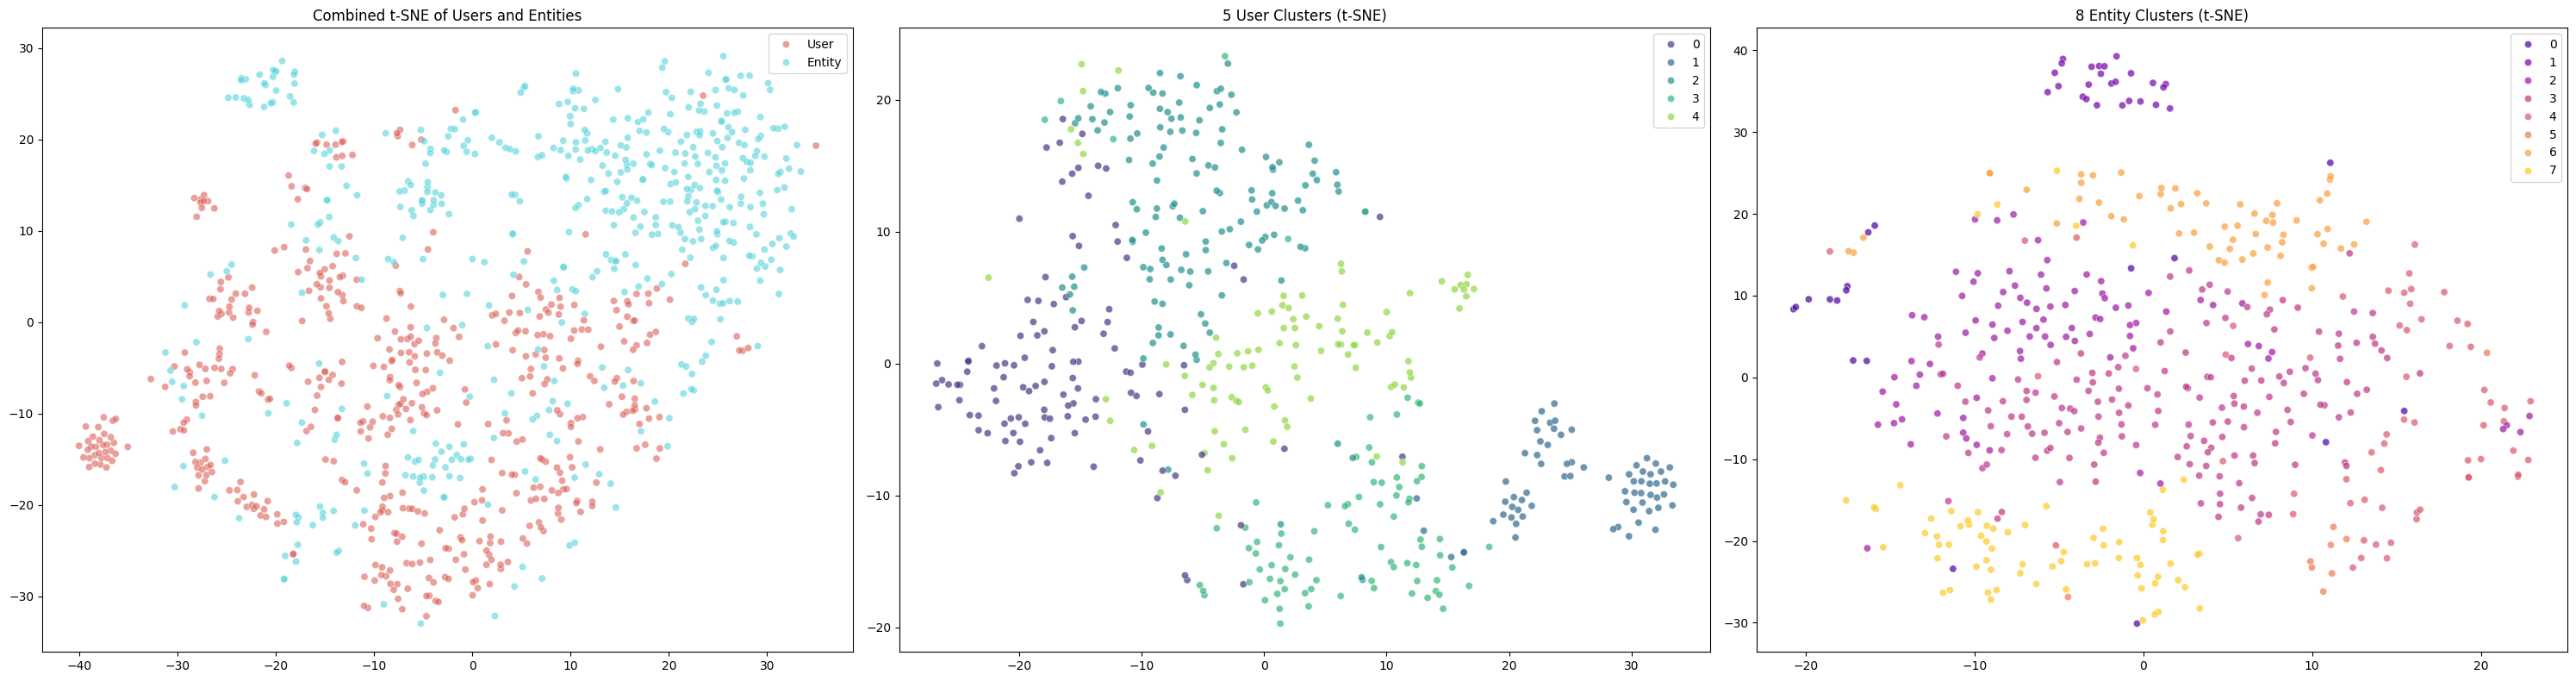


--- Interpreting 8 Entity Clusters (Filtered) ---

Cluster 0 (Size: 18 entities):
  Top 3 most frequent descriptive relations:
    - genre (appears 37 times)
    - subjects (appears 14 times)
    - author (appears 13 times)

Cluster 1 (Size: 25 entities):
  Top 3 most frequent descriptive relations:
    - works (appears 188 times)
    - works_written (appears 147 times)
    - appears_in_book (appears 19 times)

Cluster 2 (Size: 92 entities):
  Top 3 most frequent descriptive relations:
    - subjects (appears 20 times)
    - author (appears 19 times)
    - characters (appears 9 times)

Cluster 3 (Size: 160 entities):
  Top 3 most frequent descriptive relations:
    - genre (appears 19 times)
    - date_of_first_publication (appears 16 times)
    - author (appears 12 times)

Cluster 4 (Size: 62 entities):
  Top 3 most frequent descriptive relations:
    - subjects (appears 106 times)
    - genre (appears 52 times)
    - author (appears 34 times)

Cluster 5 (Size: 9 entities):
  Top 3 m

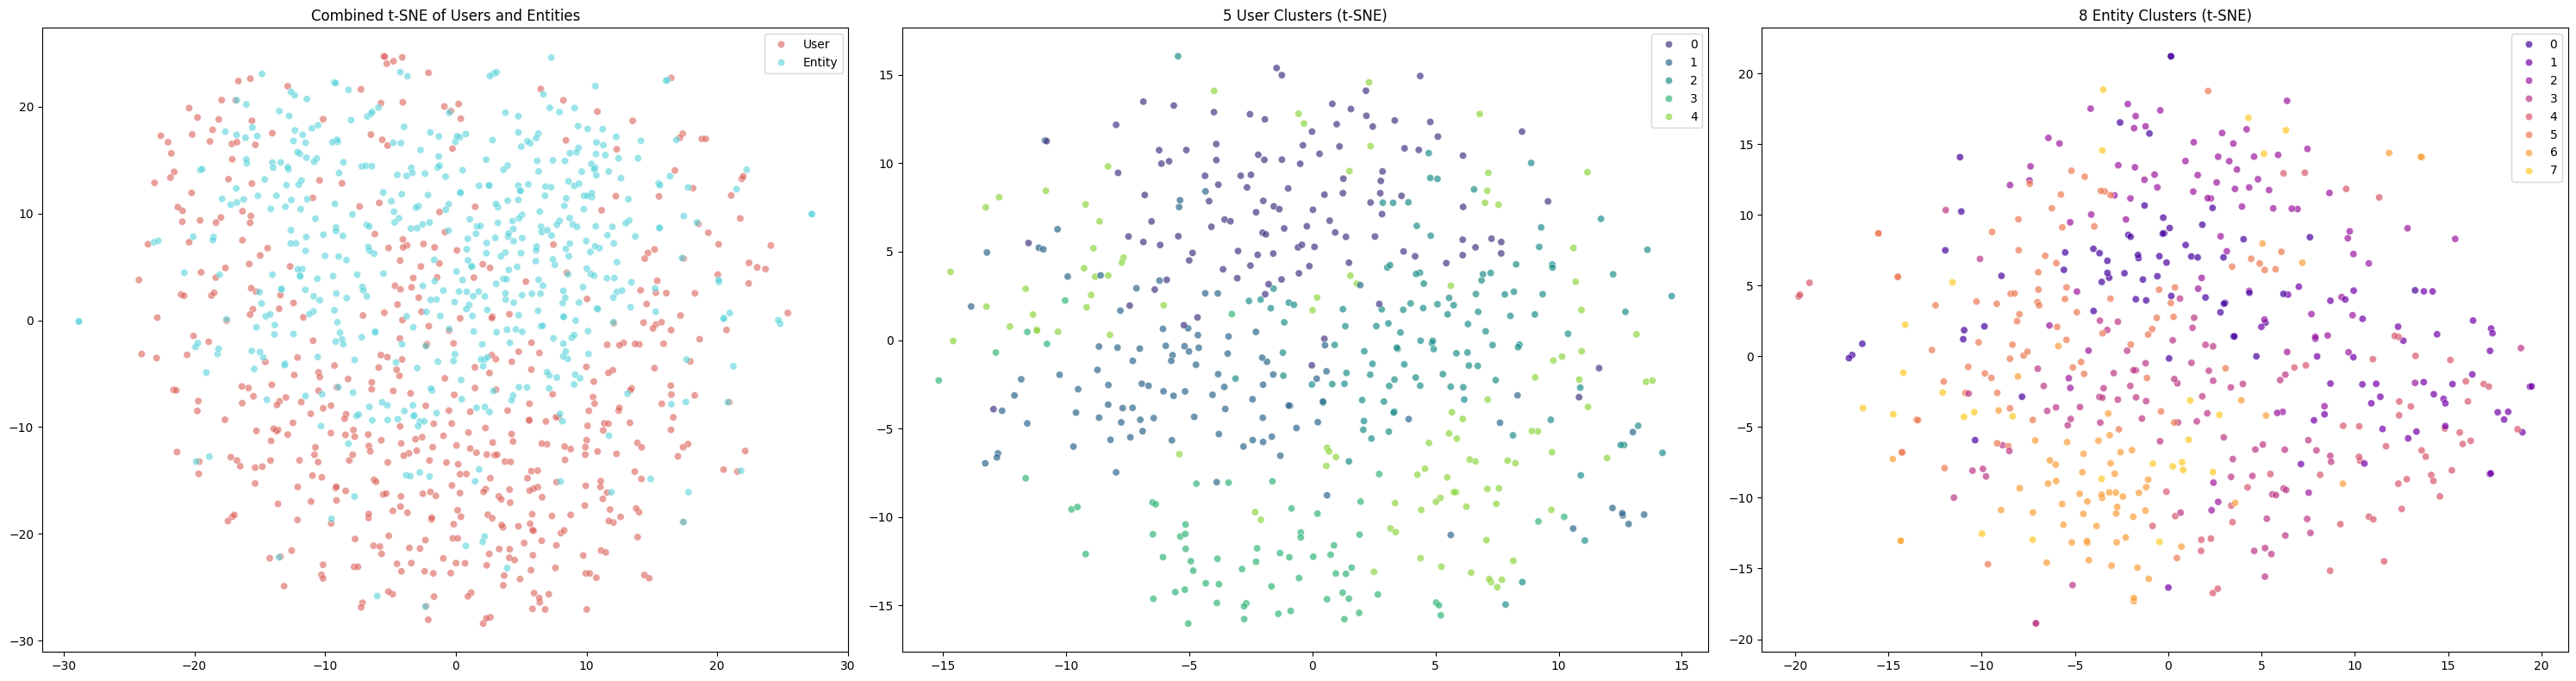


--- Interpreting 8 Entity Clusters (Filtered) ---

Cluster 0 (Size: 62 entities):
  Top 3 most frequent descriptive relations:
    - releases (appears 176 times)
    - artist (appears 38 times)
    - producer (appears 14 times)

Cluster 1 (Size: 47 entities):
  Top 3 most frequent descriptive relations:
    - releases (appears 115 times)
    - artist (appears 29 times)
    - producer (appears 10 times)

Cluster 2 (Size: 79 entities):
  Top 3 most frequent descriptive relations:
    - releases (appears 239 times)
    - artist (appears 58 times)
    - producer (appears 23 times)

Cluster 3 (Size: 81 entities):
  Top 3 most frequent descriptive relations:
    - releases (appears 121 times)
    - artist (appears 32 times)
    - producer (appears 23 times)

Cluster 4 (Size: 58 entities):
  Top 3 most frequent descriptive relations:
    - releases (appears 176 times)
    - artist (appears 34 times)
    - engineer (appears 9 times)

Cluster 5 (Size: 83 entities):
  Top 3 most frequent descri

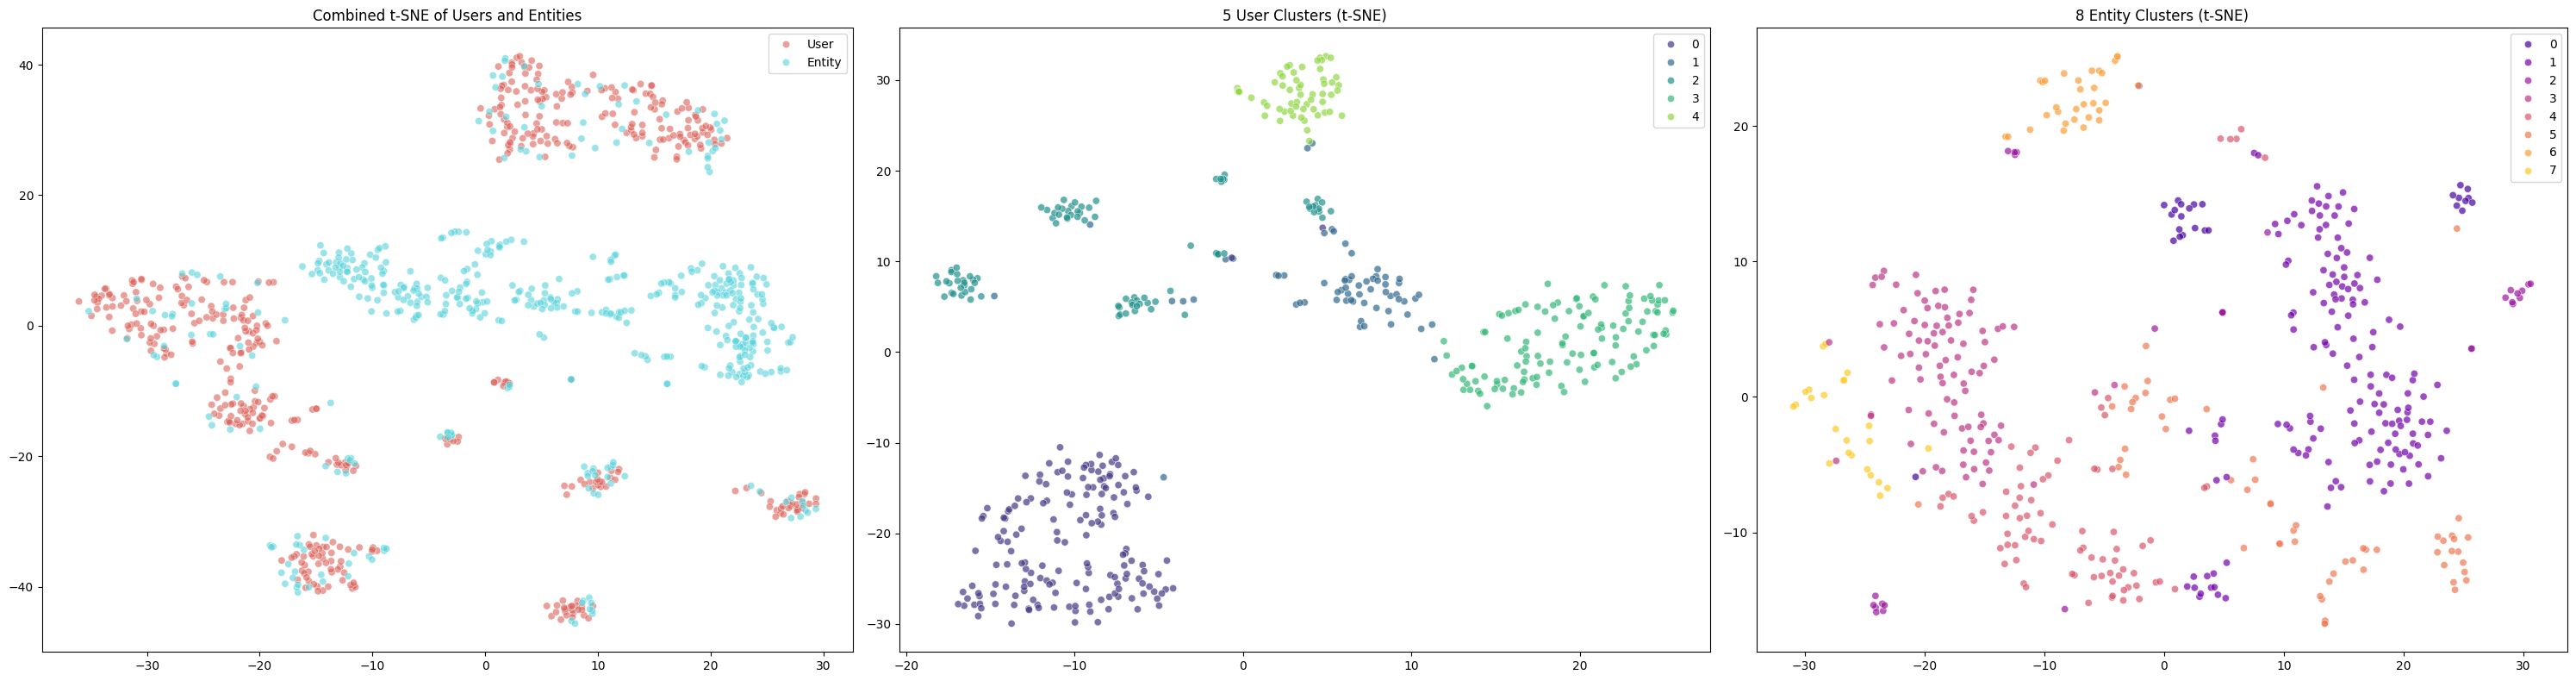


--- Interpreting 8 Entity Clusters (Filtered) ---

Cluster 0 (Size: 26 entities):
  Top 3 most frequent descriptive relations:
    - categories (appears 118 times)
    - city (appears 25 times)
    - stars (appears 25 times)

Cluster 1 (Size: 156 entities):
  Top 3 most frequent descriptive relations:
    - categories (appears 521 times)
    - state (appears 156 times)
    - city (appears 156 times)

Cluster 2 (Size: 28 entities):
  Top 3 most frequent descriptive relations:
    - categories (appears 81 times)
    - city (appears 25 times)
    - stars (appears 25 times)

Cluster 3 (Size: 95 entities):
  Top 3 most frequent descriptive relations:
    - categories (appears 369 times)
    - stars (appears 94 times)
    - state (appears 94 times)

Cluster 4 (Size: 80 entities):
  Top 3 most frequent descriptive relations:
    - categories (appears 278 times)
    - state (appears 80 times)
    - stars (appears 80 times)

Cluster 5 (Size: 60 entities):
  Top 3 most frequent descriptive rela

In [40]:
def analyze_model_performance():
    """
    Analyze trained model performance for all datasets, generating t-SNE plots
    and quality metrics for each.
    """
    # Define the list of all datasets you have trained
    datasets_to_analyze = ['amazon-book', 'last-fm', 'yelp2018']

    # Loop through each dataset to perform analysis
    for dataset in datasets_to_analyze:
        print(f"\n\n{'='*60}")
        print(f"ANALYZING MODEL FOR: {dataset.upper()}")
        print(f"{'='*60}")

        model_path = f'best_model_{dataset}.pth'

        if os.path.exists(model_path):
            # Load the corresponding data and model
            data_loader = KGATDataLoader(f"data/{dataset}")

            model = KGAT(
                data_loader=data_loader,
                embed_size=128,
                layer_sizes=[128, 64, 32]
            ).to(device)

            model.load_state_dict(torch.load(model_path))

            # Create an analyzer instance for the current model
            analyzer = KGATAnalyzer(model, data_loader)

            # Generate the t-SNE plot and calculate NP/LDD metrics
            analyzer.plot_tsne_and_metrics(n_samples=500, k=10)

            # Get a few sample recommendations
            print("\nSample recommendations:")
            for user_id in range(5):
                 if user_id in data_loader.test_user_dict:
                    recs = analyzer.get_recommendations(user_id, k=5)
                    print(f"User {user_id}: {recs}")
        else:
            print(f"No trained model found for {dataset}. Skipping analysis.")

# Make sure to call the function at the end of your script
analyze_model_performance()